<a href="https://colab.research.google.com/github/andrewponomarev/3_dl/blob/main/hw2/3_dl_hw2-part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL and Advanced DL: Домашнее задание 2

##  Содержание <a name = 'outline'></a>

* [Часть II: добавим нейронных сетей](#port_2)
    * [Задание 3](#task_3)
    * [Задание 4](#task_4)

### Часть II: добавим нейронных сетей <a name = "part_2"/>
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

Агент реализующий стратегию и вспомогательные классы находятся в [agent_dqn.py](agent_dqn.py)

In [1]:
from google.colab import files
src = list(files.upload().values())[0]
open('agent_dqn.py','wb').write(src)

Saving agent_dqn.py to agent_dqn.py


12929

In [5]:
from agent_dqn import Player, TicTacToe
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from torch.autograd import Variable
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plt.style.use('classic')

In [6]:
class Game:
    def __init__(self, p1, p2, board_rows, board_cols, num_counts):

        self.p1 = p1
        self.p2 = p2
        self.board = TicTacToe(board_rows, board_cols, num_counts)
        self.ep = 1

    def fit(self, episod_fit=1000, episod_validate=100, delta_validate=100):
        self._fig, self._ax = plt.subplots(figsize=(8, 6))
        dict_data = {-1:[], 0:[], 1:[]}
        mean_data = []
        data_x = []

        for i in tqdm(range(episod_fit+1)):
            if i % delta_validate == 0:
                mean, dict_res = self._validate(episod_validate)
                data_x.append(i)
                mean_data.append(mean)
                dict_data[1].append(dict_res[1]/episod_validate)
                dict_data[0].append(dict_res[0]/episod_validate)
                dict_data[-1].append(dict_res[-1]/episod_validate)
                self._draw_plot(episod_fit, data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])

            if i < episod_fit:
                self._run_episode(do_learning=True, greedy=False)

    def _run_episode(self, do_learning=True, greedy=False):

        self.board.reset()
        state = self.board.getHash()
        done = False
        while not done:
            # Player 1
            self.current_player = self.p1
            available_position = self.board.availablePositions()
            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if do_learning:
                    if greedy:
                        action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                    else:
                        action_tensor = self.current_player.select_action(state_tensor, available_position)
                else:
                    if greedy:
                        action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                    else:
                        action_tensor = self.current_player.select_action(state_tensor, available_position)

            self.board.updateState(action_tensor.numpy()[0][0])
            reward = self.board.get_reward()
            next_state = self.board.getHash()
            done = self.board.game_is_end()
            if do_learning:
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
                transition = (state_tensor,
                              action_tensor,
                              next_state_tensor,
                              torch.tensor([reward], dtype=torch.int32))
                if done:
                    self.p2.memory.replace_last_reward(torch.tensor([-1], dtype=torch.int32))
                self.current_player.memory.store(transition)
                self._learn()

            if done:
                return reward

            else:
                state = next_state
                # Player 2
                self.current_player = self.p2
                available_position = self.board.availablePositions()
                state_tensor = torch.tensor([state], dtype=torch.float32)
                with torch.no_grad():
                    if do_learning:
                        if greedy:
                            action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                        else:
                            action_tensor = self.current_player.select_action(state_tensor, available_position)
                    else:
                        if greedy:
                            action_tensor = self.current_player.select_random_action(available_position)
                        else:
                            action_tensor = self.current_player.select_random_action(available_position)

                self.board.updateState(action_tensor.numpy()[0][0])
                reward = self.board.get_reward()
                next_state = self.board.getHash()
                done = self.board.game_is_end()

                if do_learning:
                    next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
                    transition = (state_tensor,
                                  action_tensor,
                                  next_state_tensor,
                                  torch.tensor([-reward], dtype=torch.int32))
                    if done:
                        self.p1.memory.replace_last_reward(torch.tensor([-1], dtype=torch.int32))
                    self.current_player.memory.store(transition)
                    self._learn()

                if done:
                    return reward
                state = next_state

    def _transform_state_to_action(self, matrix_output, batch_state):
        result = np.zeros(batch_state.shape[0])
        for i in range(batch_state.shape[0]):
            ind = self.board.availablePositionsBoard(batch_state[i])
            if len(ind)>0:
                result[i] = np.max(matrix_output[i][ind])
            else:
                result[i] = np.max(matrix_output[i])
        return result

    def _learn(self):
        mem = self.current_player.memory
        if len(mem.memory) < self.current_player.batch_size:
            return

        transitions = mem.sample(self.current_player.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        Q = self.current_player.model(batch_state).gather(1, batch_action).reshape([self.current_player.batch_size])

        model_next_state = self.current_player.model(batch_next_state)

        Qmax = torch.tensor(self._transform_state_to_action(model_next_state.detach().numpy(),
                                                            batch_next_state),
                            dtype=torch.float32)
        Qnext = batch_reward + (self.current_player.gamma * Qmax)

        loss = F.smooth_l1_loss(Q, Qnext)
        self.current_player.optimizer.zero_grad()
        loss.backward()
        self.current_player.optimizer.step()

    def _validate(self, episod_validate):
        counts = 0
        dict_res = {-1:0, 0:0, 1:0}
        for i in range(episod_validate):
            rew = self._run_episode(do_learning=False, greedy=True)
            dict_res[rew] += 1
            counts += rew
        mean = counts/episod_validate
        return mean, dict_res

    def _draw_plot(self, rounds, data_x, data_y, data_y1, data_y2, data_y3):
        self._ax.clear()
        self._ax.plot(data_x, data_y1, 'go-', label='Доля побед')
        self._ax.plot(data_x, data_y2, 'b^--', label='Доля ничьих')
        self._ax.plot(data_x, data_y3, 'rs-.', label='Доля поражений')
        self._ax.set_title('Исходы игры',
                           fontdict={'fontsize': 12},
                           )
        self._ax.set_ylabel('Доля побед, ничьих, поражений',
                            fontdict={'fontsize': 10},
                            )
        self._ax.set_xlabel('Итерации обучения',
                            fontdict={'fontsize': 10},
                            )
        self._ax.legend(loc='best')
        self._ax.set_xlim([0, rounds])
        self._ax.set_ylim([0, 1.0])
        self._fig.canvas.draw()

#### Задание 3  <a name = "task_3"/>
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

<b> Доска 3 x 3 </b>

  0%|          | 0/1501 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



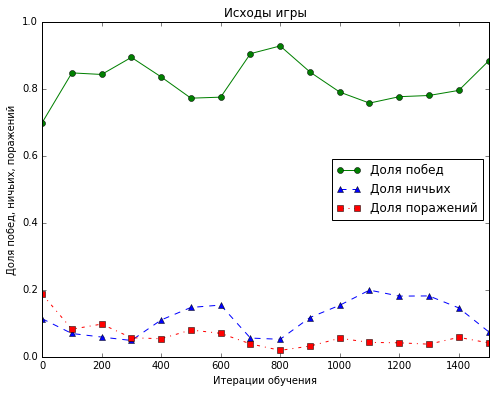

In [7]:
%matplotlib inline

board_cols, board_rows, num_counts = 3, 3, 3

player_1 = Player(board_cols,
                  board_rows,
                  type_network='DQN',
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
player_2 = Player(board_cols,
                  board_rows,
                  type_network='DQN',
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
game = Game(player_1,
            player_2,
            board_rows,
            board_cols,
            num_counts
            )

game.fit(episod_fit=1500,
         episod_validate=10000,
         delta_validate=100,
         )

<b> Доска 4 x 4 </b>

  0%|          | 0/4001 [00:00<?, ?it/s]

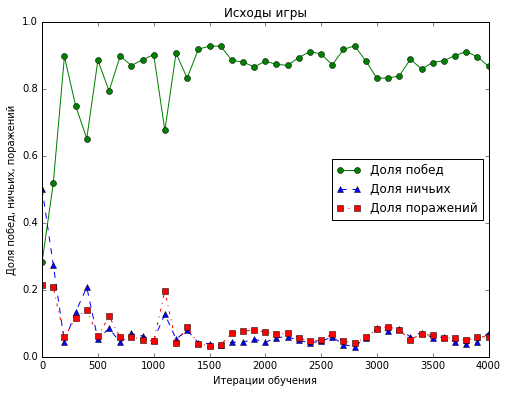

In [8]:
%matplotlib inline

board_cols, board_rows, num_counts = 4, 4, 4

player_1 = Player(board_cols,
                  board_rows,
                  type_network="DQN",
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
player_2 = Player(board_cols,
                  board_rows,
                  type_network="DQN",
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
game = Game(player_1,
            player_2,
            board_rows,
            board_cols,
            num_counts
            )

game.fit(episod_fit=4000,
         episod_validate=10000,
         delta_validate=100,
         )

#### Задание 4  <a name = "task_4"/>
Реализуйте Double DQN и/или Dueling DQN.

<b> доска 3 x 3 </b>

  0%|          | 0/1501 [00:00<?, ?it/s]

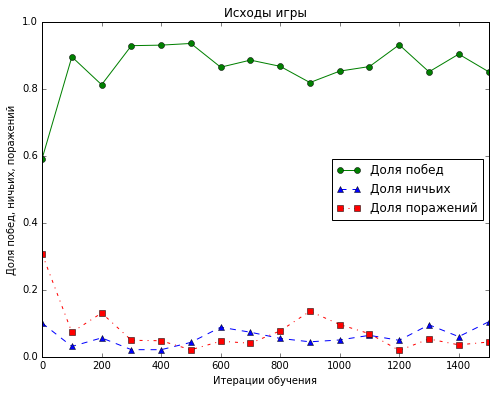

In [9]:
%matplotlib inline

board_cols, board_rows, num_counts = 3, 3, 3

player_1 = Player(board_cols,
                  board_rows,
                  type_network='DuelingDQN',
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
player_2 = Player(board_cols,
                  board_rows,
                  type_network='DuelingDQN',
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )

game = Game(player_1,
            player_2,
            board_rows,
            board_cols,
            num_counts
            )

game.fit(episod_fit=1500,
         episod_validate=10000,
         delta_validate=100,
         )

<b> Доска 4 x 4 </b>

  0%|          | 0/4001 [00:00<?, ?it/s]

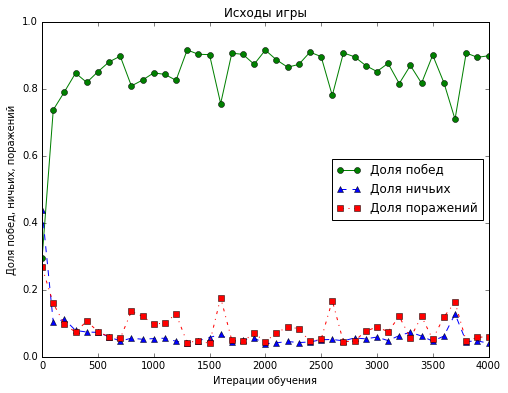

In [10]:
%matplotlib inline

board_cols, board_rows, num_counts = 4, 4, 4

player_1 = Player(board_cols,
                  board_rows,
                  type_network="DuelingDQN",
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
player_2 = Player(board_cols,
                  board_rows,
                  type_network="DuelingDQN",
                  lr=0.001,
                  gamma=0.8,
                  batch_size=64,
                  size_memory=10000
                  )
game = Game(player_1,
            player_2,
            board_rows,
            board_cols,
            num_counts
            )

game.fit(episod_fit=4000,
         episod_validate=10000,
         delta_validate=100,
         )